In [31]:
import h5py
import mpld3
import glob

from scipy.optimize import curve_fit
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

def pruned_indices(array):
    indices = []
    for element in array:
        indices.append(np.where(array==element)[0][0])
    indices = np.array(list(set(indices)))
    return indices

def frequencies_gen(f):
    frequencies = np.array([])
    info = f['Step config']['Resonator 1 RF - Frequency']['Step items']
    for block in info:
        new_frequencies = np.linspace(block[3], block[4], block[8])
        frequencies = np.hstack([frequencies, new_frequencies])
    frequencies = np.array(sorted(list(set(frequencies))))
    return frequencies

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


def iq_loader(path):
    
    hdf_files = glob.glob(path+'/*.hdf5')

    if len(hdf_files) == 1:
        
        f = h5py.File(hdf_files[0], 'r')
  
        idf = pd.DataFrame(f['Traces']['daqbox - CH1 In DC I'][:,0,:].T)
        n_samples = idf.shape[1]
        dt = f['Traces']['daqbox - CH1 In DC I_t0dt'][0,1]
        idf.columns = dt*np.arange(n_samples)
        
        qdf = pd.DataFrame(f['Traces']['daqbox - CH1 In DC Q'][:,0,:].T)
        n_samples = qdf.shape[1]
        dt = f['Traces']['daqbox - CH1 In DC Q_t0dt'][0,1]
        qdf.columns = dt*np.arange(n_samples)
        
        frequencies = frequencies_gen(f)
        
        f.close()
        
    else:
        with open(glob.glob(path+'/*I.txt')[0], 'r') as f:
            idf = pd.read_csv(f, skiprows=5, sep='\t')
        with open(glob.glob(path+'/*Q.txt')[0], 'r') as f:
            qdf = pd.read_csv(f, skiprows=5, sep='\t')

        with open(glob.glob(path+'/*I.txt')[0], 'r') as f:
            a = f.readline()
            a = f.readline()
            a = f.readline()
            frequencies = f.readline()
            a = f.readline()

        frequencies = frequencies.split('\n')[0]
        frequencies = frequencies.split('\t')
        frequencies = np.array([float(freq) for freq in frequencies])
        frequencies = frequencies[0::2]
        
    frequencies *= 1e-9

    columns = idf.columns
    new_columns = np.array([float(index) for index in columns])
    idf.columns = new_columns*1000000

    columns = qdf.columns
    new_columns = np.array([float(index) for index in columns])
    qdf.columns = new_columns*1000000

    iup = idf.iloc[1::2]
    iup.index = np.arange(iup.shape[0])
    idown = idf.iloc[0::2]
    idown.index = np.arange(idown.shape[0])
    idiff = iup - idown
    n_runs = idiff.shape[0]

    qup = qdf.iloc[1::2]
    qup.index = np.arange(qup.shape[0])
    qdown = qdf.iloc[0::2]
    qdown.index = np.arange(qdown.shape[0])
    #c = qdown.columns
    #nc = np.array([float(element) for element in c])
    #qdown.columns = nc
    qdiff = qup - qdown

    up = iup + qup*1j
    down = idown + qdown*1j
    
    n_frequencies = up.shape[0]
    frequencies = frequencies[0:n_frequencies]
    
    up.index = frequencies
    down.index = frequencies
    
    return down, up


def iq_loader_variation(path):
    
    hdf_files = glob.glob(path+'/*.hdf5')
    
    f = h5py.File(hdf_files[0], 'r')
    
    frequencies = frequencies_gen(f)
    frequencies *= 1e-9
    n_frequencies = frequencies.shape[0]
    idown = pd.DataFrame(f['Traces']['daqbox - CH1 In DC I'][:,0,0:n_frequencies].T)
    iup = pd.DataFrame(f['Traces']['daqbox - CH1 In DC I'][:,0,-n_frequencies:].T)
    qdown = pd.DataFrame(f['Traces']['daqbox - CH1 In DC Q'][:,0,0:n_frequencies].T)
    qup = pd.DataFrame(f['Traces']['daqbox - CH1 In DC Q'][:,0,-n_frequencies:].T)
    dt = f['Traces']['daqbox - CH1 In DC I_t0dt'][0,1]
    n_samples = idown.shape[1]
    idown.columns = dt*np.arange(n_samples)
    qdown.columns = dt*np.arange(n_samples)
    iup.columns = dt*np.arange(n_samples)
    qup.columns = dt*np.arange(n_samples)

    columns = idown.columns
    new_columns = np.array([float(index) for index in columns])
    idown.columns = new_columns*1000000

    columns = qdown.columns
    new_columns = np.array([float(index) for index in columns])
    qdown.columns = new_columns*1000000

    columns = iup.columns
    new_columns = np.array([float(index) for index in columns])
    iup.columns = new_columns*1000000

    columns = qup.columns
    new_columns = np.array([float(index) for index in columns])
    qup.columns = new_columns*1000000

    up = iup + qup*1j
    down = idown + qdown*1j
    
    n_frequencies = up.shape[0]
    frequencies = frequencies[0:n_frequencies]
    
    up.index = frequencies
    down.index = frequencies
    
    return down, up

def decay(t, ar, ai, br, bi, T):
    signal_r = ar - br*np.exp(-t/T)
    signal_i = ai - bi*np.exp(-t/T)
    signal = np.array([signal_r, signal_i])
    return signal

def decay_flat(t, ar, ai, br, bi, T):
    index = int(len(t)/2)
    return decay(t[0:index], ar, ai, br, bi, T).flatten()

def decay(t, ar, ai, br, bi, T):
    signal_r = ar - br*np.exp(-t/T)
    signal_i = ai - bi*np.exp(-t/T)
    signal = np.array([signal_r, signal_i])
    return signal

def decay_flat(t, ar, ai, br, bi, T):
    index = int(len(t)/2)
    return decay(t[0:index], ar, ai, br, bi, T).flatten()

def fit_and_plot(paths, axes=0, t_end_sweep=[200, 200, 1]):
    measured_powers = [float(path) for path in paths]

    frames = []
    for power, path in zip(measured_powers, paths):
        subdirs = [x[0] for x in os.walk(path)]
        if len(subdirs) != 1:
            subdirs = subdirs[1:]
        subframes = []
        for subdir in subdirs:
            frequencies, t_constants, percentage_deviation, trial_t_constants, spectrum, best_popt, trial_popt = iq_fitter_trial(subdir, t0_sweep=[10,20,6], t_end_sweep=t_end_sweep)
            t_frame = pd.DataFrame([t_constants])
            t_frame.index = [power]
            t_frame.columns = frequencies
            subframes.append(t_frame)
        new_frame = pd.concat(subframes, axis=1, join='inner')
        frames.append(new_frame)
    combined = pd.concat(frames)
    
    return combined, frequencies, t_constants, percentage_deviation, trial_t_constants, spectrum, best_popt, trial_popt

def iq_fitter(path, t0_sweep=[10, 15, 6], t_end_sweep=[200, 200, 1], state='up'):

    with open(path+'/pulse_length.txt') as f:
        pulse_length = f.readline()
    pulse_length = float(pulse_length)
    
    with open(path+'/pulse_length.txt') as f:
        info = f.readlines()
    pulse_length = info[0].split('\n')[0]
    pulse_length = float(pulse_length)
    
    if len(info) > 1:
        if info[1] == 'variation':
            down, up = iq_loader_variation(path)
    else:
        down, up = iq_loader(path)
        
    if os.path.exists(path+'/flags.txt'):
        flags = pd.read_csv(path+'/flags.txt', header=None)
        flags = flags.values[0,:]
        down = down.drop(down.index[flags])
        up = up.drop(up.index[flags])
    
    if state == 'up':
        diff = up
    elif state == 'down':
        diff = down
    elif state == 'diff':
        diff = up - down
    else:
        print('Faulty state input.')
    
    n_runs = down.shape[0]
    
    frequencies = down.index

    t_end = pulse_length
    
    start_times = np.linspace(t0_sweep[0], t0_sweep[1], t0_sweep[2], endpoint=True)
    n_trials = start_times.shape[0]

    t_constants = np.zeros(n_runs)
    spectrum = np.zeros(n_runs, dtype=np.complex128)
    
    variances = np.zeros([n_runs, n_trials])
    trial_t_constants = np.zeros([n_runs, n_trials])
    trial_popt = np.zeros([n_runs,start_times.shape[0],5])
    
    for i in range(n_runs):
        spec_run = down.iloc[i][250:299]
        spec_point = np.mean(spec_run)
        spectrum[i] = spec_point
        for j, t0 in enumerate(start_times):
            
            #if j >= t0_sweep[2]:
            #    run = diff.iloc[i][t0:t_end]
            #else:
            #    run = diff.iloc[i][t0:t_end]
            run = diff.iloc[i][t0:t_end]
            start = np.mean(run[t0:t0+0.5]) 
            end = np.mean(run[t_end-0.5:t_end])
            y_noisy = np.hstack([run.real, run.imag])
            times = run.index
            t_tiled = np.tile(run.index, 2)

            ar = end.real
            ai = end.imag
            br = start.real
            bi = start.imag
            T = 5
            try:
                popt, pcov = curve_fit(f=decay_flat, xdata=t_tiled, ydata=y_noisy, p0=[ar, ai, br, bi, T])
                trial_popt[i,j,:] = popt
                variances[i,j] = pcov[4,4]
                trial_t_constants[i,j] = popt[4]
            except:
                variances[i,j] = np.nan
                trial_t_constants[i,j] = np.nan
                trial_popt[i,j,:] = np.nan
        
    percentage_deviation = np.sqrt(variances)/trial_t_constants
    min_indices = np.nanargmin(percentage_deviation, axis=1)
    best_popt = trial_popt[np.arange(min_indices.shape[0]),min_indices]
        
    t_constants = np.array([trial_t_constants[k,min_index] for k, min_index in enumerate(min_indices)])

    return frequencies, t_constants, percentage_deviation, trial_t_constants, spectrum, best_popt, trial_popt


def plot_time_constants(combined, combined_errors, ax=None, loc=0, fmt='-o', ls='-', marker='o', show_errors=True):
    
    if ax is None:
    
        mpl.rcParams['figure.figsize'] = (12,8)

        font = {'weight' : 'normal',
                'size'   : 22}

        matplotlib.rc('font', **font)

        fig, ax = plt.subplots(1,1)

    n_runs = combined.shape[0]

    for i in range(n_runs):
        pruned_constants = combined.iloc[i].dropna()
        pruned_errors = combined_errors.iloc[i].dropna()
        #combined.iloc[i].dropna().plot(ax=axes)
        #axes.scatter(combined.iloc[i].index, combined.iloc[i])
        if show_errors:
            axes.errorbar(pruned_constants.index, pruned_constants, yerr=pruned_errors, fmt=fmt)
        else:
            axes.plot(pruned_constants.index, pruned_constants, marker=marker, ls=ls)
    axes.legend(combined.index, loc=loc, title='Power (dBm)')
    axes.set_xlabel('Drive frequency / GHz')
    axes.set_ylabel(r'Time constant / $\mu$s')
    
    
def group_fitter(paths, state='diff', t0_sweep=[10,20,3]):
    measured_powers = [float(path) for path in paths]

    frames = []
    error_frames = []
    for power, path in zip(measured_powers, paths):
        subdirs = [x[0] for x in os.walk(path)]
        if len(subdirs) != 1:
            subdirs = subdirs[1:]
        subframes = []
        error_subframes = []
        for subdir in subdirs:
            frequencies, t_constants, percentage_deviation, trial_t_constants, spectrum, best_popt, trial_popt = iq_fitter(subdir, t0_sweep=t0_sweep, t_end_sweep=[200,200,1], state=state)
            trial_errors = trial_t_constants*percentage_deviation
            #indices = np.nanargmin(trial_errors, axis=1)
            indices = np.nanargmin(percentage_deviation, axis=1)
            n_points = indices.shape[0]
            errors = trial_errors[np.arange(n_points), indices]
            pd_use = percentage_deviation[np.arange(n_points), indices]
            t_constants = trial_t_constants[np.arange(n_points), indices]
            #mask = pd_use < 0.2
            mask = np.full(pd_use.shape[0], True)
            errors = errors[mask]
            t_constants = t_constants[mask]
            frequencies = frequencies[mask]
            error_frame = pd.DataFrame([errors])
            error_frame.index = [power]
            error_frame.columns = frequencies
            t_frame = pd.DataFrame([t_constants])
            t_frame.index = [power]
            t_frame.columns = frequencies
            subframes.append(t_frame)
            error_subframes.append(error_frame)
        new_frame = pd.concat(subframes, axis=1, join='inner')
        new_error_frame = pd.concat(error_subframes, axis=1, join='inner')
        columns = [f for f in new_frame.columns]
        new_frame = new_frame.sort_index(axis=1)
        new_error_frame = new_error_frame.sort_index(axis=1)
        indices = pruned_indices(new_frame.columns)
        new_frame = new_frame.iloc[:,indices]
        new_error_frame = new_error_frame.iloc[:,indices]
        frames.append(new_frame)
        error_frames.append(new_error_frame)
    combined = pd.concat(frames)
    combined_errors = pd.concat(error_frames)
    return combined, combined_errors


def df_to_da(df):
    da = xr.DataArray(df.values,coords=[df.index,df.columns], dims=['power','fd'])
    return da

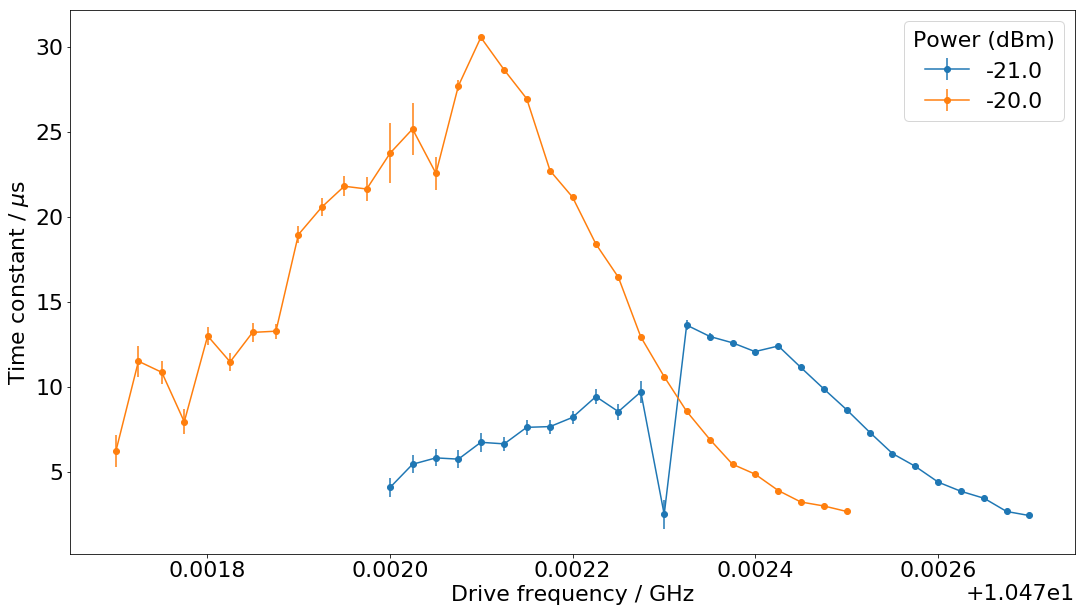

In [50]:
mpld3.disable_notebook()

paths = ['-21','-20']
combined, combined_errors = group_fitter(paths, state='up', t0_sweep=[10,10,1])
combined.columns -= 0.125
combined_errors.columns -= 0.125

time_constants = df_to_da(combined)
errors = df_to_da(combined_errors)
results_dict = dict()
results_dict['constants'] = time_constants
results_dict['errors'] = errors
results = xr.Dataset(results_dict)
results.to_netcdf('exp_results.nc')

matplotlib.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,1,figsize=(18,10))

plot_time_constants(combined, combined_errors, ax=axes, fmt='-o')

plt.savefig('10th_cooldown.png')

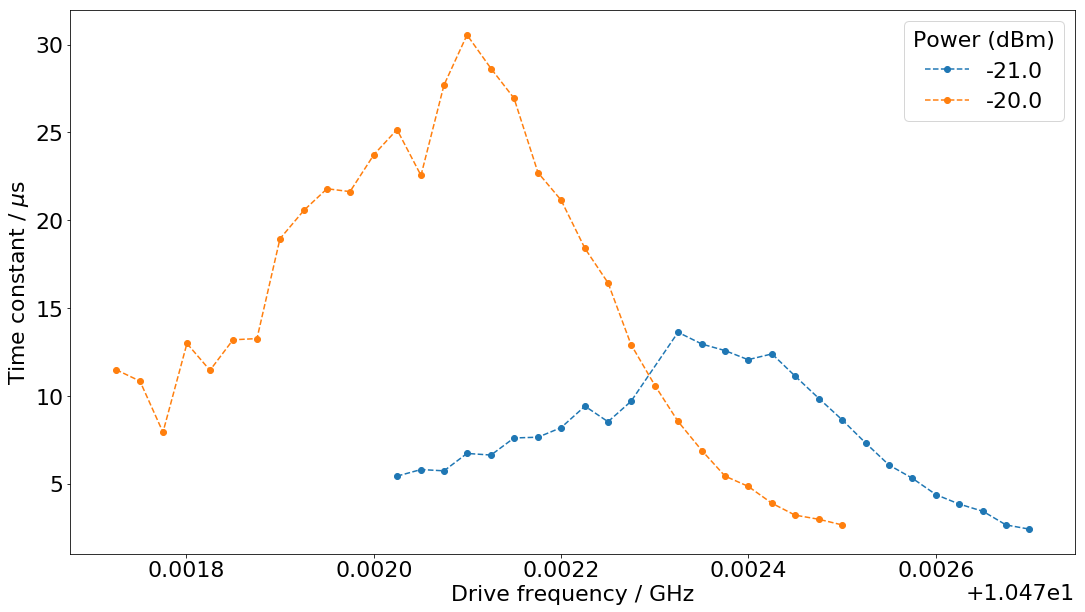

In [54]:
import matplotlib

mask = ( combined_errors / combined ) < 0.1

matplotlib.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,1,figsize=(18,10))

plot_time_constants(combined[mask], combined_errors[mask], ax=axes, ls='--', marker='o', show_errors=False)

plt.savefig('10th_cooldown_clean.png')

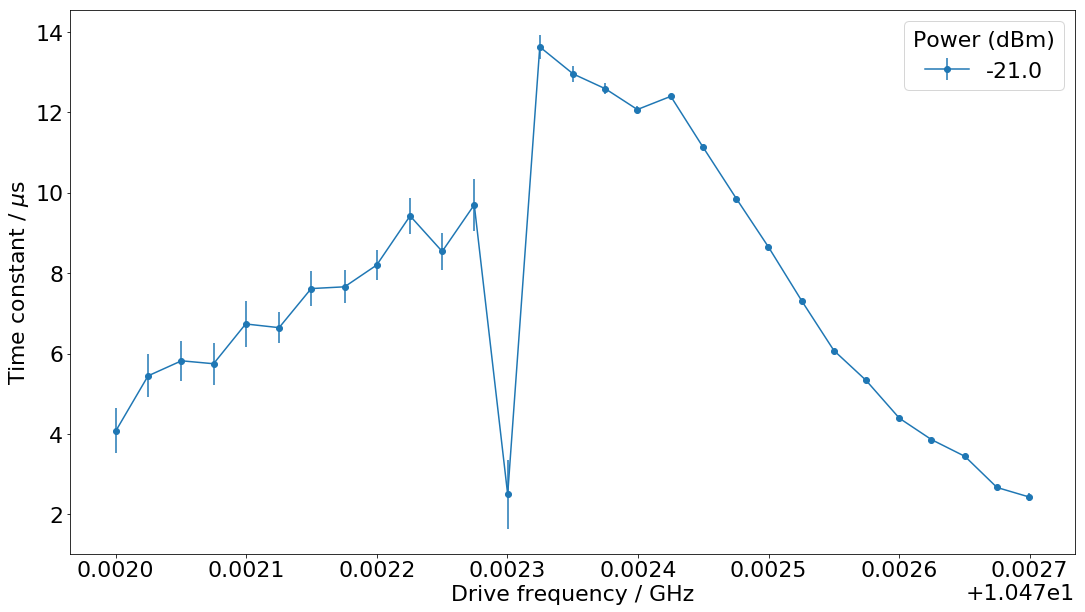

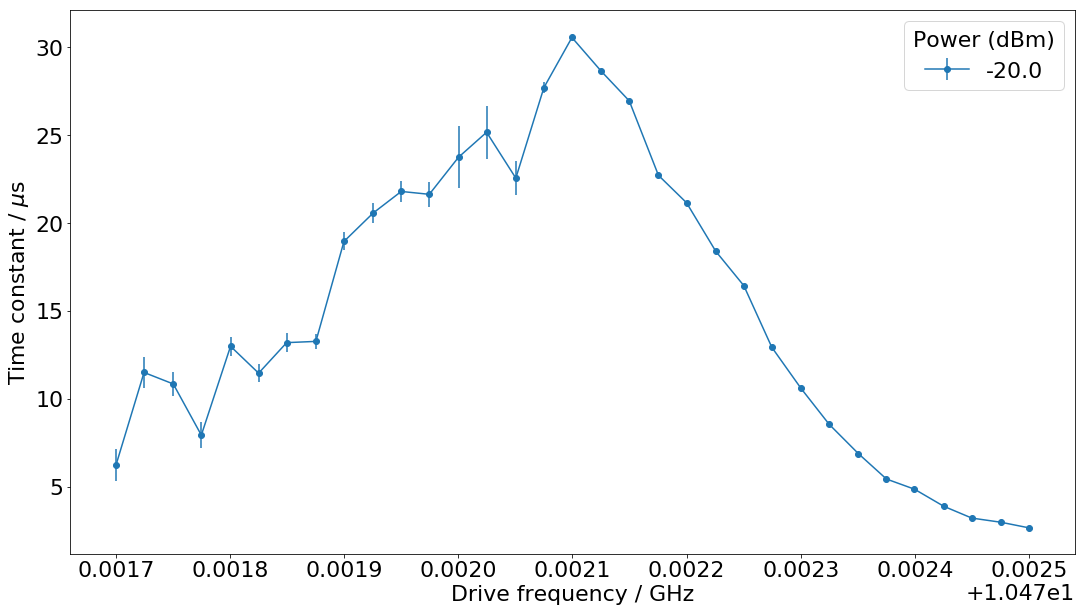

In [56]:
import matplotlib

n_powers = combined.shape[0]

mask = ( combined_errors / combined ) < 1.0

for i in range(n_powers):
    
    power = combined.index[i]

    matplotlib.rcParams.update({'font.size': 22})
    fig, axes = plt.subplots(1,1,figsize=(18,10))

    plot_time_constants(combined[mask].iloc[i:i+1], combined_errors[mask].iloc[i:i+1], ax=axes, fmt='-o')

    plt.savefig('8th_cooldown_3rd_switching_times_noisy_' + str(power) + 'dBm.png')

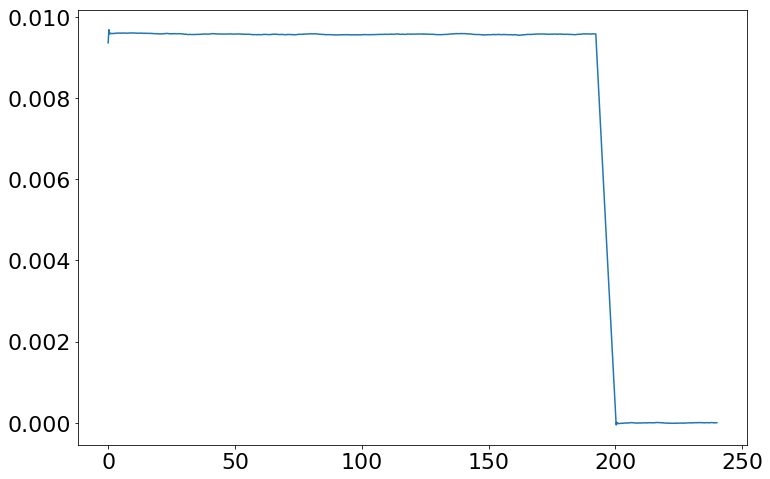

In [60]:
N = 1000
i = 0
smoothed = np.convolve(down.iloc[i], np.ones((N,))/N, mode='valid')
time = down.iloc[i].index[0:-(N-1)]

fig, axes = plt.subplots(1,1)
i_min = 1000
i_min = 0
i_max = 30000
axes.plot(time[i_min:i_max],smoothed[i_min:i_max])

$T_{sw} = \frac{1}{1/T_b + 1/T_d}$


$T_d \rightarrow \infty$


$T_{sw} \rightarrow T_b$

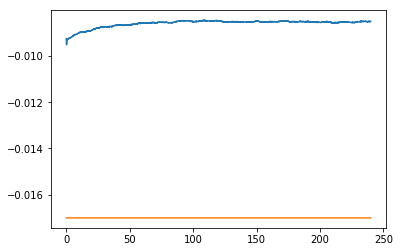

In [74]:
def decay_test(t, A, B, T):
    #return A*np.exp(-t/T) + B
    #return B*np.ones(t.shape[0])
    return A*np.exp(-t/200) + B


time_trunc = np.array(time[i_min:i_max])
smoothed_trunc = smoothed[i_min:i_max].real


A_est = smoothed_trunc[-1]
B_est = smoothed_trunc[-1]
T_est = 1


popt, pcov = curve_fit(f=decay_test, xdata=time_trunc, ydata=smoothed_trunc ,p0=[A_est,B_est,T_est])


fig, axes = plt.subplots(1,1)
axes.plot(time_trunc, smoothed_trunc)
#axes.plot(time_trunc, decay_test(smoothed_trunc, *popt))
axes.plot(time_trunc, decay_test(smoothed_trunc, *[A_est, B_est, T_est]))